In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [3]:
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['savefig.facecolor'] = 'none'

In [4]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

In [5]:
PLOTS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'behavior', 'hand')

In [6]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [7]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 2), 'gaze_analysis', 'features')
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

In [8]:
MOUSE_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data', 'mouse', 'compressed')

### Firstly, get the cleaned mouse data

In [9]:
MOUSE_CLEANED_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data', 'mouse', 'cleaned')

In [10]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [11]:
from tqdm import tqdm

from utils.mouse_motion import (
    PHASE_OFFSETS, aggregate_stroke_events, stroke_detected_to_dicts
)

def save_all_cleaned_motions():
    for subj in tqdm(all_subjs):
        subj_f = f'{subj}.npz'
        subj_src_path = os.path.join(MOUSE_DATA_FOLDER, subj_f)
        subj_des_path = os.path.join(MOUSE_CLEANED_DATA_FOLDER, subj_f)
        if not os.path.exists(subj_des_path):
            subj_source_data = np.load(subj_src_path)
            strokes = aggregate_stroke_events(subj_source_data, PHASE_OFFSETS)
            stroke_dicts = stroke_detected_to_dicts(strokes)
            np.savez(subj_des_path, **stroke_dicts)

In [12]:
# save_all_cleaned_motions()

## load pair-up behavior and motion data

In [13]:
BEHAV_PATH = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data', 'behavior', 'subjects')

def load_hand_motion_subj(subj):
    # load motion data
    subj_motion_path = os.path.join(
        MOUSE_CLEANED_DATA_FOLDER, f'{subj}.npz')
    subj_motion_data = np.load(subj_motion_path)
    # load df
    subj_df = pd.read_csv(
        os.path.join(BEHAV_PATH, f'{subj}.csv'),
        index_col=0)
    return subj_motion_data, subj_df


## Firstly, check the magnitude

In [14]:
from utils.eye_trial import generate_events

EVENTS = generate_events()

In [15]:
MODE_COLORS = {
    'draw': 'skyblue',
    'click': 'coral',
}

In [16]:
EVENTS

OrderedDict([('s1 onset', 1000),
             ('s1 cue onset', 1250),
             ('s1 delay mask onset', 1750),
             ('s1 delay onset', 2250),
             ('s2 onset', 3250),
             ('s2 cue onset', 3500),
             ('s2 delay mask onset', 4000),
             ('s2 delay onset', 4500),
             ('response', 9500)])

In [17]:
from utils.mouse_motion import compute_subj_motion_mags, T_TOTAL
from utils.eye_plotting import annotate_time_line
from scipy.ndimage import convolve1d

def collect_all_subjs_motion_mags(lmb, mag_normalize=True):
    collected = {}
    for subj in all_subjs:
        subj_motion_data, subj_df = load_hand_motion_subj(subj)
        subj_mags = compute_subj_motion_mags(
            subj_motion_data, subj_df, lmb, mag_normalize=mag_normalize)
        collected[subj] = subj_mags
    return collected

def bridge_phase_gaps(data, gap_size=70):
    data = data.copy()
    gap_names = [
        's1 cue onset', 's1 delay mask onset',
        's2 onset', 's2 cue onset', 's2 delay mask onset']
    gap_time_points = [EVENTS[k] for k in gap_names]
    # the gap in delay
    gap_time_points.append(EVENTS['s2 delay onset'] + 1000)
    # interpolate the gap
    for gap_id in gap_time_points:
        gap_start = gap_id - gap_size
        gap_end = gap_id + gap_size
        interpolated = np.linspace(
            data[:, gap_start], 
            data[:, gap_end], 
            gap_end-gap_start+1).T
        data[:, gap_start:gap_end+1] = interpolated
    return data

def plot_motion_mag_with_mask(ax, lmb, label=None, line_color='gray', mag_normalize=True, smooth_window=51):
    subj_mag_aggregated = collect_all_subjs_motion_mags(lmb, mag_normalize=mag_normalize)
    subj_mag_aggregated = [subj_mag_aggregated[k] for k in subj_mag_aggregated]
    subj_mag_aggregated = np.array(subj_mag_aggregated)

    # bridge the gaps
    subj_mag_aggregated = bridge_phase_gaps(subj_mag_aggregated)

    # smoothing
    if smooth_window > 1:
        subj_mag_aggregated = convolve1d(
            subj_mag_aggregated, 
            np.ones(smooth_window)/smooth_window, 
            axis=1, mode='constant', cval=0.0)
            
    # plot it
    mean_mag = np.mean(subj_mag_aggregated, axis=0)
    sem_mag = np.std(subj_mag_aggregated, axis=0) / np.sqrt(len(subj_mag_aggregated))
    ax.plot(mean_mag, color=line_color, label=label)
    ax.fill_between(
        np.arange(T_TOTAL), 
        mean_mag-sem_mag, mean_mag+sem_mag, color=line_color, alpha=0.3)
    annotate_time_line(ax, EVENTS)

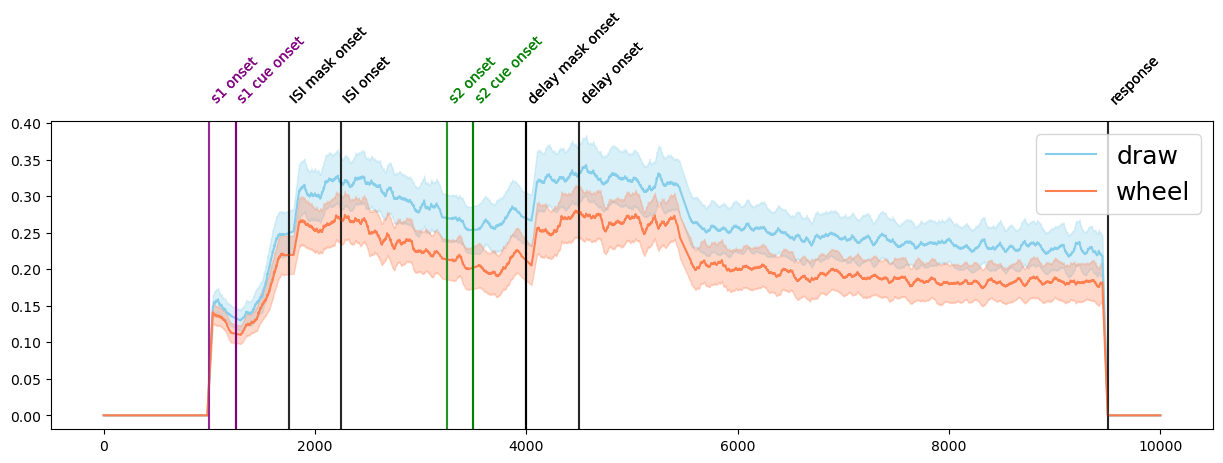

In [18]:
fig, ax = plt.subplots(1, figsize=(15, 4))
draw_lmb = lambda d: (d['mode'] == 'draw').to_numpy()
plot_motion_mag_with_mask(ax, draw_lmb, label='draw', line_color=MODE_COLORS['draw'], mag_normalize=False)
click_lmb = lambda d: (d['mode'] == 'click').to_numpy()
plot_motion_mag_with_mask(ax, click_lmb, label='wheel', line_color=MODE_COLORS['click'], mag_normalize=False)
ax.legend(fontsize=18)

plot_path = os.path.join(PLOTS_FOLDER, 'mode_hand_mag.png')
plt.savefig(plot_path)

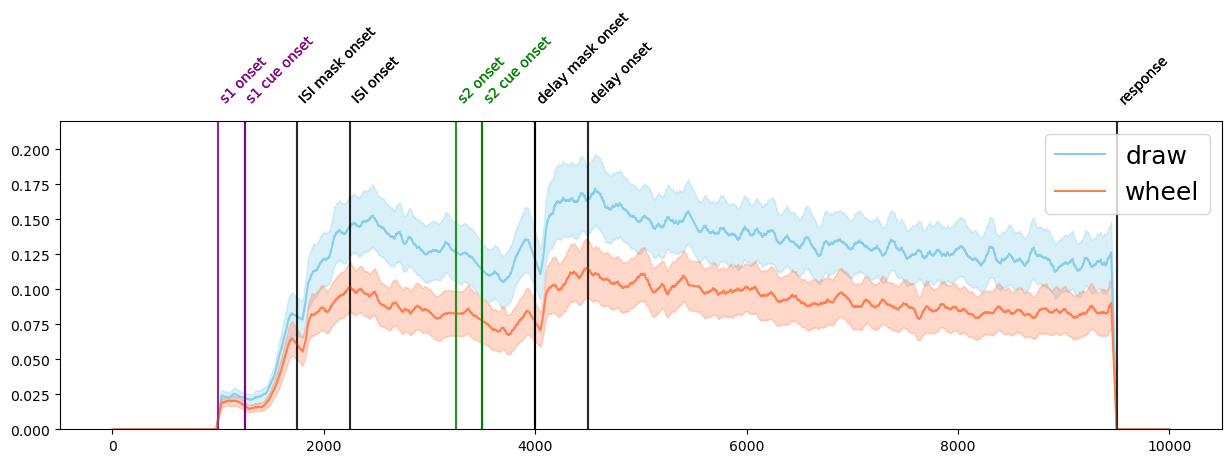

In [19]:
fig, ax = plt.subplots(1, figsize=(15, 4))
draw_lmb = lambda d: (d['mode'] == 'draw').to_numpy()
plot_motion_mag_with_mask(ax, draw_lmb, label='draw', line_color=MODE_COLORS['draw'], mag_normalize=True)
click_lmb = lambda d: (d['mode'] == 'click').to_numpy()
plot_motion_mag_with_mask(ax, click_lmb, label='wheel', line_color=MODE_COLORS['click'], mag_normalize=True)
ax.set_ylim([0, 0.22])
ax.legend(fontsize=18)

plot_path = os.path.join(PLOTS_FOLDER, 'mode_hand_freq.png')
plt.savefig(plot_path)

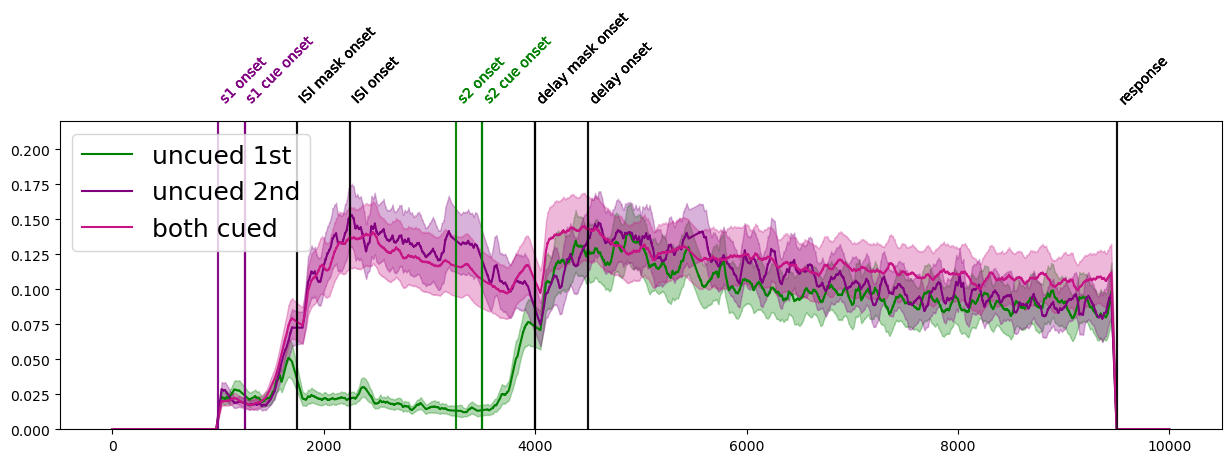

In [20]:
fig, ax = plt.subplots(1, figsize=(15, 4))
uncued_1st_lmb = lambda d: (
    (d['trial_code']==0) & (~(d['stim_1_to_report']))).to_numpy()
plot_motion_mag_with_mask(ax, uncued_1st_lmb, label='uncued 1st', line_color='green')
uncued_2nd_lmb = lambda d: (
    (d['trial_code']==0) & (~(d['stim_2_to_report']))).to_numpy()
plot_motion_mag_with_mask(ax, uncued_2nd_lmb, label='uncued 2nd', line_color='purple')
bothcued_lmb = lambda d: (~(uncued_1st_lmb(d) | uncued_2nd_lmb(d)))
plot_motion_mag_with_mask(ax, bothcued_lmb, label='both cued', line_color='mediumvioletred')
ax.set_ylim([0, 0.22])
ax.legend(fontsize=18)

plot_path = os.path.join(PLOTS_FOLDER, 'stim1_hand_freq.png')
plt.savefig(plot_path)


## Check relevance: RSA or inverted encoding

In [21]:
from scipy.ndimage import gaussian_filter1d
from utils.mouse_motion import dicts_to_stroke_events, convert_cleaned_to_table

class HandAngleFeatureExtractor:
    def __init__(self, settings):
        self.settings = settings
        self.initialize()

    def initialize(self):
        pass

    def convert_subj_motion_data(self, subj_motion_data, N_trials, mag_normalize=False):
        # convert to angle and motions
        subj_events = dicts_to_stroke_events(subj_motion_data)
        subj_motions = convert_cleaned_to_table(
            subj_events, N_trials, T_TOTAL, mag_normalize=mag_normalize)
        subj_angles = subj_motions[..., 0]
        subj_mag = subj_motions[..., 1]
        return subj_angles, subj_mag

    def bin_data(self, data):
        time_bin = self.settings['time_binning']['timebin_size']
        # assuming the last dimension is time dimension
        shape_original = data.shape
        t_original = shape_original[-1]
        n_bins = t_original // time_bin
        data = data[..., :n_bins * time_bin]
        data = data.reshape(*shape_original[:-1], n_bins, time_bin)
        return data

    def angle_to_ids(self, angles):
        n_angle_bins = self.settings['angle_to_id']['n_angle_bins']
        to_fold = self.settings['angle_to_id']['to_fold']
        epoch = 180 if to_fold else 360
        angles = angles % epoch
        angle_bin_size = epoch / n_angle_bins 
        angle_bin_ids = (angles + angle_bin_size/2) / angle_bin_size
        angle_bin_ids = angle_bin_ids.astype(int) % n_angle_bins
        # print(angles[:2, :2, :3], angle_bin_ids[:2, :2, :3])
        return angle_bin_ids
    
    def batch_process_1dids(self, state_ids, weights):
        filter_zero = self.settings['occurence']['filter_zero']
        n_states = self.settings['angle_to_id']['n_angle_bins']
        
        assert len(state_ids.shape) == 3 
        n_trials, n_time_bins, timebin_size = state_ids.shape
        
        # compute number of occurence each trial, each time point
        occurences = None
        if filter_zero:
            occurences = np.sum(weights>0, axis=-1, keepdims=True)
        else:
            occurences = np.ones((n_trials, n_time_bins, 1)) * timebin_size

        # aggregate
        # output: n_trials * n_time_bins * n_states
        results = np.zeros((n_trials, n_time_bins, n_states))
        trial_indices, time_indices, state_indices = np.meshgrid(
            np.arange(n_trials), np.arange(n_time_bins), np.arange(timebin_size), indexing='ij'
        )
        np.add.at(
            results, 
            (trial_indices.ravel(), time_indices.ravel(), state_ids.ravel()), 
            weights.ravel())

        # normalize
        occ_non_zero = np.where(occurences>0, occurences, 1)
        results = results / occ_non_zero

        return results
    
    def convert_collapsed_1dvec(self, angles, mag_weights):
        # sum everything up
        angle_ids = self.angle_to_ids(angles)
        n_states = self.settings['angle_to_id']['n_angle_bins']
        h = np.zeros(n_states)
        np.add.at(h, angle_ids.flatten(), mag_weights.flatten())
        # normalization: count number of occurences
        filter_zero = self.settings['occurence']['filter_zero']
        n_occurences = np.sum(mag_weights > 0).astype(int) if filter_zero else np.size(xs)
        h = h / n_occurences

        return h
    
    def convert_eyedata_1dvec(self, angles, mag_weights):
        # aggreagte each time bin
        angles_binned = self.bin_data(angles)
        mag_weights_binned = self.bin_data(mag_weights)

        # convert angle to angle bin id
        angle_ids_binned = self.angle_to_ids(angles_binned)

        # now compute the collapsed
        results = self.batch_process_1dids(angle_ids_binned, mag_weights_binned)

        return results
        
    def get_subject_features(self, subj_motion_data, N_trials):
        # apply center normalization if needed  
        angles, mag_weights = self.convert_subj_motion_data(
            subj_motion_data, N_trials, mag_normalize=True)      
        
        # NOTE: input data should have been subject-normalized
        results = self.convert_eyedata_1dvec(angles, mag_weights)

        # also compute the subject bias, using the norm_phases
        subj_vec = self.convert_collapsed_1dvec(angles, mag_weights)
        
        # normalization: remove subject bias
        results = results - subj_vec

        # finally, apply smoothing
        smoothing_params = self.settings.get('smoothing')
        if smoothing_params is not None:
            results = gaussian_filter1d(
                results, 
                sigma=smoothing_params['sigma'], 
                mode='wrap', axis=-1)
        
        return results

In [22]:
# 1d
DEFAULT_1D_VEC_SETTINGS = {
    'occurence': {
        'filter_zero': True,
    },
    'angle_to_id': {
        'n_angle_bins': 30,
        'to_fold': False,
    },
    'time_binning': {
        'timebin_size': 50,
    },
    'dist_metric': 'cos',
    'smoothing': {
        'sigma': 2,
    }
}

In [23]:
feature_extractor = HandAngleFeatureExtractor(DEFAULT_1D_VEC_SETTINGS)

In [24]:
MOUSE_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data', 'mouse', 'features')

def extract_subj_hand_1d_feature(subj):
    subj_feature_path = os.path.join(MOUSE_FEATURE_FOLDER, '1d', f'{subj}.npy')
    if not os.path.exists(subj_feature_path):
        # load data
        subj_motion_data, subj_df = load_hand_motion_subj(subj)
        N_trials = len(subj_df)
        subj_motion_features = feature_extractor.get_subject_features(
            subj_motion_data, N_trials)
        # save data
        np.save(subj_feature_path, subj_motion_features)

In [25]:
for subj in tqdm(all_subjs):
    extract_subj_hand_1d_feature(subj)

100%|██████████| 36/36 [00:00<00:00, 2342.75it/s]


#### Read the outputs

In [26]:
def get_last_response(row):
    if pd.isna(row['resp_1_last_drawing_tend']) and pd.isna(row['resp_2_last_drawing_tend']):
        return np.nan
    elif pd.isna(row['resp_1_last_drawing_tend']):
        return row['resp_2']
    elif pd.isna(row['resp_2_last_drawing_tend']):
        return row['resp_1']
    else:
        return row['resp_2'] if row['resp_2_last_drawing_tend'] > row['resp_1_last_drawing_tend'] else row['resp_1']

def behav_df_add_last_response(df):
    df['current_last_response'] = df.apply(get_last_response, axis=1)
    df_copy = df[['participant', 'block', 'trial', 'current_last_response']].copy()
    df_copy['trial'] += 1  # Increment trial to match the next row's trial
    df_copy = df_copy.rename(columns={'current_last_response': 'prev_last_response'})
    df = df.merge(df_copy, on=['participant', 'block', 'trial'], how='left')
    return df

In [27]:
CLEANED_BEHAV_FOLDER_PATH = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data', 'mouse', 'psychopy')

def read_padded_behav_df(subj):
    subj_behav_path = os.path.join(CLEANED_BEHAV_FOLDER_PATH, f'{subj}.csv')
    if not os.path.exists(subj_behav_path):
        src_df = pd.read_csv(
            os.path.join(BEHAV_PATH, f'{subj}.csv'), index_col=0)
        padded = behav_df_add_last_response(src_df)
        padded.to_csv(subj_behav_path, index=False)
    subj_df = pd.read_csv(subj_behav_path)
    return subj_df


In [28]:
def load_subject_time_feature(subj, time_steps, normalize=True):
    subj_feature_path = os.path.join(MOUSE_FEATURE_FOLDER, '1d', f'{subj}.npy')
    features = np.load(subj_feature_path)
    features = features[:, time_steps]
    features = np.mean(features, axis=1)

    if normalize:
        # normalize at the given time point
        # Z-score normalization
        means = np.mean(features, axis=0)  # Mean of each column
        stds = np.std(features, axis=0)    # Standard deviation of each column
        features = (features - means) / (stds + 1e-5)
        # clip to remove outlier
        clip_range = 5 
        features = np.clip(features, -clip_range, clip_range)
        # convert all to non-negative
        features = (features + clip_range) / (2 * clip_range)

    # also load the behavior data
    behavior_data = read_padded_behav_df(subj)

    return features, behavior_data

### Visualization of Features

In [29]:
def load_all_subj_hand_features(time_phase):
    # load all features
    all_features = []
    all_dfs = []
    for subj in all_subjs:
        subj_features, subj_df = load_subject_time_feature(subj, time_phase)
        all_features.append(subj_features)
        all_dfs.append(subj_df)

    all_features = np.concatenate(all_features, axis=0)
    all_dfs = pd.concat(all_dfs, ignore_index=True)
    return all_features, all_dfs


In [30]:
def abs_angle_diff(x1, x2):
    d1 = np.abs(x1 - x2)
    d2 = 180 - d1
    ds = np.min([d1, d2], axis=0)
    return ds

def divide_by_condition(nbins, features, dfs, stim_ids):
    # features shape: n_trial x n_feature
    # create pattern according to stim
    angle_bins = (180 / nbins) * (np.arange(nbins)) # + 0.5)
    project_ids = []
    for stim_id in stim_ids:
        map_id = np.argmin(abs_angle_diff(
            dfs[stim_id].to_numpy()[:, None], angle_bins[None, :]), axis=1)
        project_ids.append(map_id)
    project_ids = np.array(project_ids).T

    bin_patterns = np.zeros((nbins, features.shape[-1]))
    for bin_id in range(nbins):
        mask = (project_ids == bin_id).any(axis=1)
        bin_patterns[bin_id] = np.mean(features[mask], axis=0)
    
    return bin_patterns, angle_bins

In [31]:
N_BINS = 8

In [32]:
delay_phase = np.arange(start=4750//50, stop=9250//50).astype(int)

In [33]:
LABEL_FONT_SIZE = 20
AX_TITLE_SIZE=40

In [34]:
from matplotlib.patches import Wedge
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_single_1d_plot_color(d1_pattern, angle, ax, set_title=True):
    # re-center
    d1_pattern = d1_pattern - np.mean(d1_pattern)
    # normalization
    norm_values = d1_pattern / np.max(np.abs(d1_pattern))
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    cmap = cm.bwr
    n_bins = len(d1_pattern)
    angle_step = 360 / n_bins
    for i in range(n_bins):
        end_angle = (90-(i * angle_step)) % 360
        start_angle = (90-((i+1) * angle_step)) % 360
        color = cmap(norm(norm_values[i]))
        wedge = Wedge((0, 0), 1, start_angle, end_angle, color=color)
        ax.add_patch(wedge)

    # plot the grating bar
    bar_length = 0.5
    bar_rad = np.radians(90 - angle)
    ax.plot(
        [-np.cos(bar_rad)*bar_length, np.cos(bar_rad)*bar_length],
        [-np.sin(bar_rad)*bar_length, np.sin(bar_rad)*bar_length],
        lw=50, c='purple')
    
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    if set_title:
        ax.set_title(f'{angle:.0f}°', fontsize=AX_TITLE_SIZE*3)

def plot_single_1d_plot_vectors(d1_pattern, angle, ax, set_title=True):
    # re-center
    d1_pattern = d1_pattern - 0.5

    # rescale
    scale = np.max(np.abs(d1_pattern))
    baseline_scale = 0.7
    rescale_factor = 0.3
    norm_values = d1_pattern / scale * rescale_factor + baseline_scale

    n_bins = len(d1_pattern)
    angle_step = 360 / n_bins

    # define start points
    plot_angles = (90-((np.arange(n_bins)+0.5) * angle_step)) % 360
    plot_rads = np.deg2rad(plot_angles)
    center_offset = 0.05
    xs, ys = center_offset * np.cos(plot_rads), center_offset * np.sin(plot_rads)

    # define vectors
    vec_len_factor = 1.2
    vec_len = norm_values * vec_len_factor
    us, vs = np.cos(plot_rads) * vec_len, np.sin(plot_rads) * vec_len

    # plot a circle at background
    cir_r = vec_len_factor * baseline_scale + center_offset
    circle = plt.Circle(
        (0, 0), radius=cir_r, fill=False, edgecolor='lightgray', linewidth=2)
    ax.add_patch(circle)

    # quiver
    ax.quiver(
        xs, ys, us, vs,
        angles='xy', scale_units='xy', scale=1,
        width=0.03, color='gray',
        headwidth=2, headaxislength=2, headlength=2)

    
    # plot the grating bar
    bar_length = 0.5
    bar_rad = np.radians(90 - angle)
    ax.plot(
        [-np.cos(bar_rad)*bar_length, np.cos(bar_rad)*bar_length],
        [-np.sin(bar_rad)*bar_length, np.sin(bar_rad)*bar_length],
        lw=50, c='purple')
    
    plot_scale = 1.2
    ax.set_xlim([-plot_scale, plot_scale])
    ax.set_ylim([-plot_scale, plot_scale])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    if set_title:
        ax.set_title(f'{angle:.0f}°', fontsize=AX_TITLE_SIZE*3)


In [35]:
def plot_1d_plot(d1_patterns, angles, axs, set_title=True, method='vector'):
    n_bins = len(d1_patterns)
    for i in range(n_bins):
        single_plot_params = {
            'd1_pattern': d1_patterns[i],
            'angle': angles[i],
            'ax': axs[i],
            'set_title': set_title
        }
        
        if method == 'color':
            plot_single_1d_plot_color(**single_plot_params)
        elif method == 'vector':
            plot_single_1d_plot_vectors(**single_plot_params)
        else:
            raise ValueError(f'Unknown method: {method}')

In [36]:
all_hand_delay_features,all_hand_df = load_all_subj_hand_features(delay_phase)

In [37]:
stim1_only_mask = (
    (all_hand_df['trial_code'] == 0) &
    (all_hand_df['stim_1_to_report']) &
    (~all_hand_df['stim_2_to_report'])
).to_numpy()
stim2_only_mask = (
    (all_hand_df['trial_code'] == 0) &
    (~all_hand_df['stim_1_to_report']) &
    (all_hand_df['stim_2_to_report'])
).to_numpy()

In [38]:
def compute_delay_patterns(lmb):
    mask = np.ones(len(all_hand_df), dtype=bool)
    if lmb is not None:
        mask = lmb(all_hand_df)

    stim1_mask = stim1_only_mask & mask
    stim2_mask = stim2_only_mask & mask

    stim1_only_full_delay_patterns, angle_bins = divide_by_condition(
        nbins=N_BINS, features=all_hand_delay_features[stim1_mask], 
        dfs=all_hand_df[stim1_mask], 
        stim_ids=['stim_1',])
    stim2_only_full_delay_patterns, _ = divide_by_condition(
        nbins=N_BINS, features=all_hand_delay_features[stim2_mask], 
        dfs=all_hand_df[stim2_mask], 
        stim_ids=['stim_2',])
    full_delay_only1 = (
        stim1_only_full_delay_patterns + stim2_only_full_delay_patterns) / 2
    return full_delay_only1, angle_bins

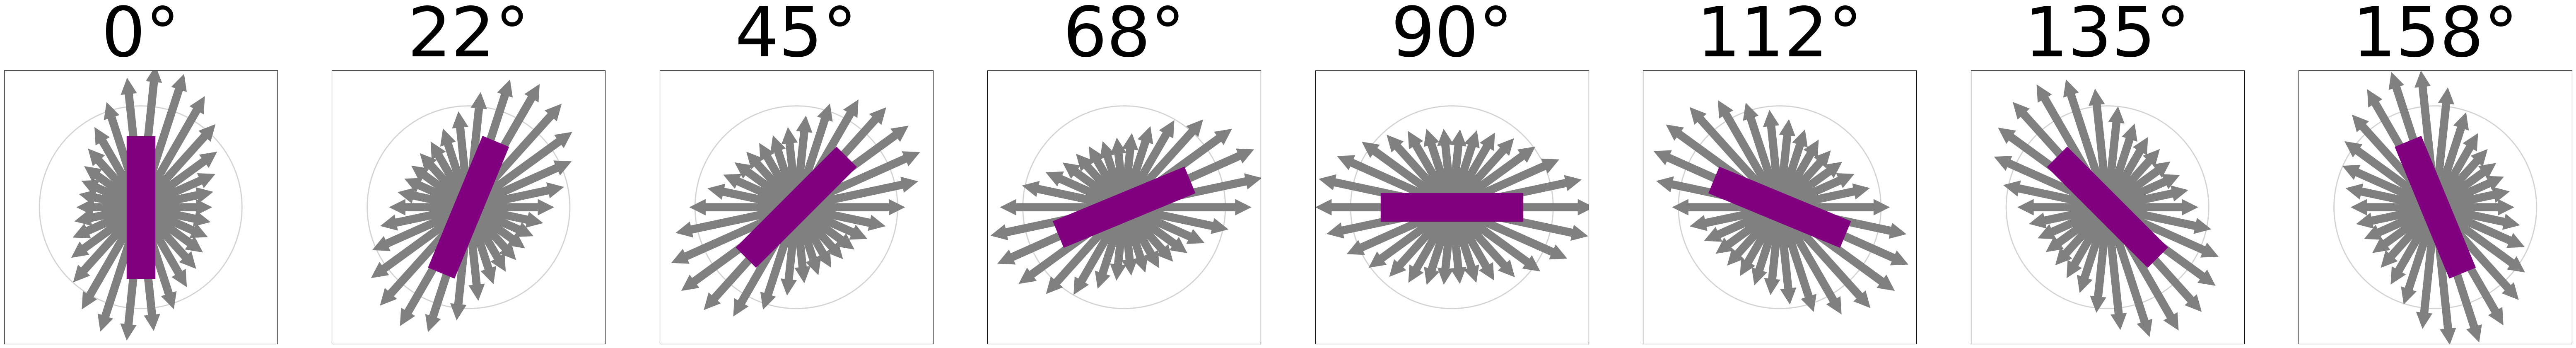

In [39]:
hand_full_delay_only1, angle_bins = compute_delay_patterns(None)

fig, ax = plt.subplots(1, N_BINS, figsize = (10*N_BINS, 10))
plot_1d_plot(hand_full_delay_only1, angle_bins, ax, method='vector')

hand_delay_plot_only1_path = os.path.join(PLOTS_FOLDER, 'delay_feature_vector.png')
plt.savefig(hand_delay_plot_only1_path)

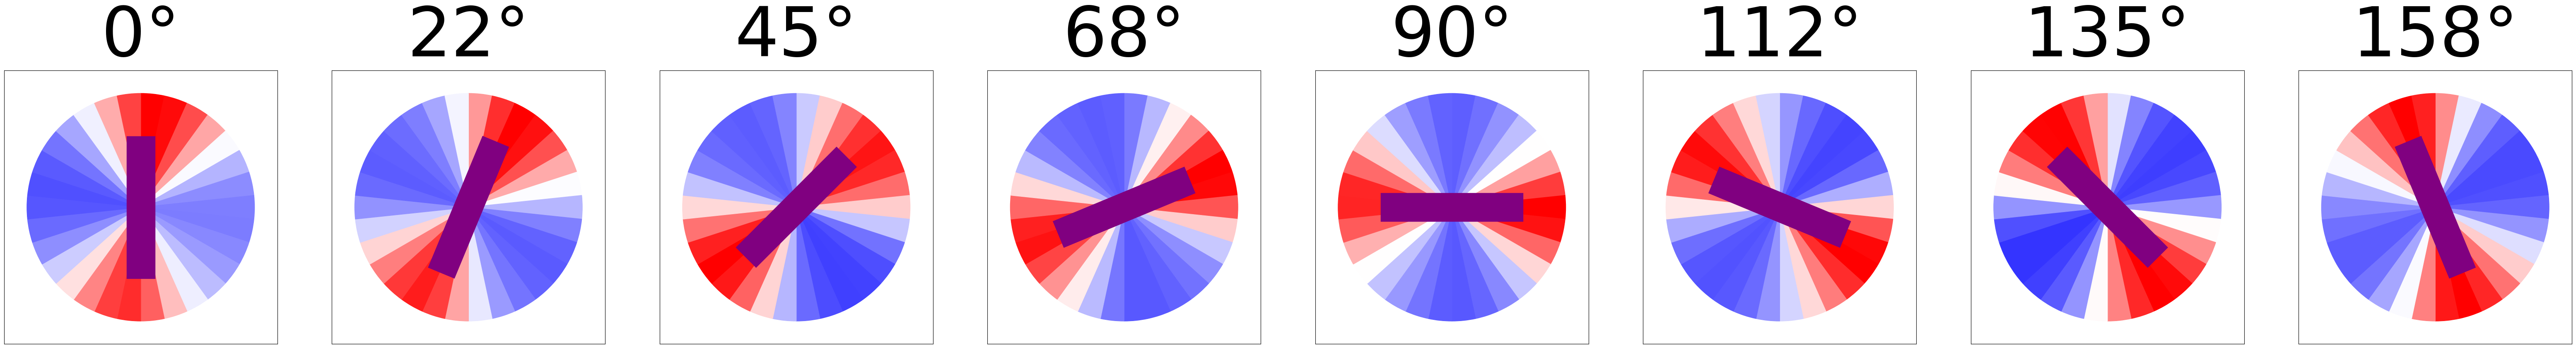

In [40]:
fig, ax = plt.subplots(1, N_BINS, figsize = (10*N_BINS, 10))
plot_1d_plot(hand_full_delay_only1, angle_bins, ax, method='color')

hand_delay_plot_only1_path = os.path.join(PLOTS_FOLDER, 'delay_feature_color.png')
plt.savefig(hand_delay_plot_only1_path)

##### separate the mode

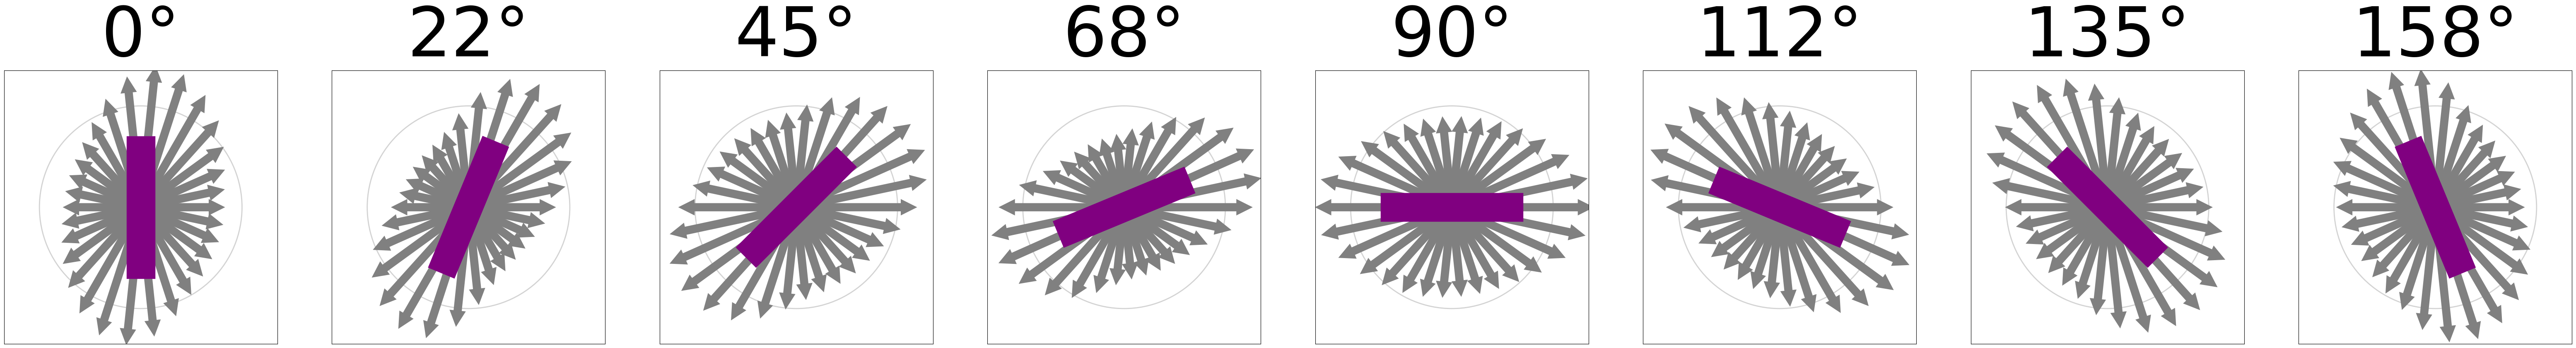

In [41]:
draw_hand_full_delay_only1, angle_bins = compute_delay_patterns(draw_lmb)

fig, ax = plt.subplots(1, N_BINS, figsize = (10*N_BINS, 10))
plot_1d_plot(draw_hand_full_delay_only1, angle_bins, ax, method='vector')

hand_delay_plot_only1_path = os.path.join(PLOTS_FOLDER, 'draw_delay_feature_vector.png')
plt.savefig(hand_delay_plot_only1_path)

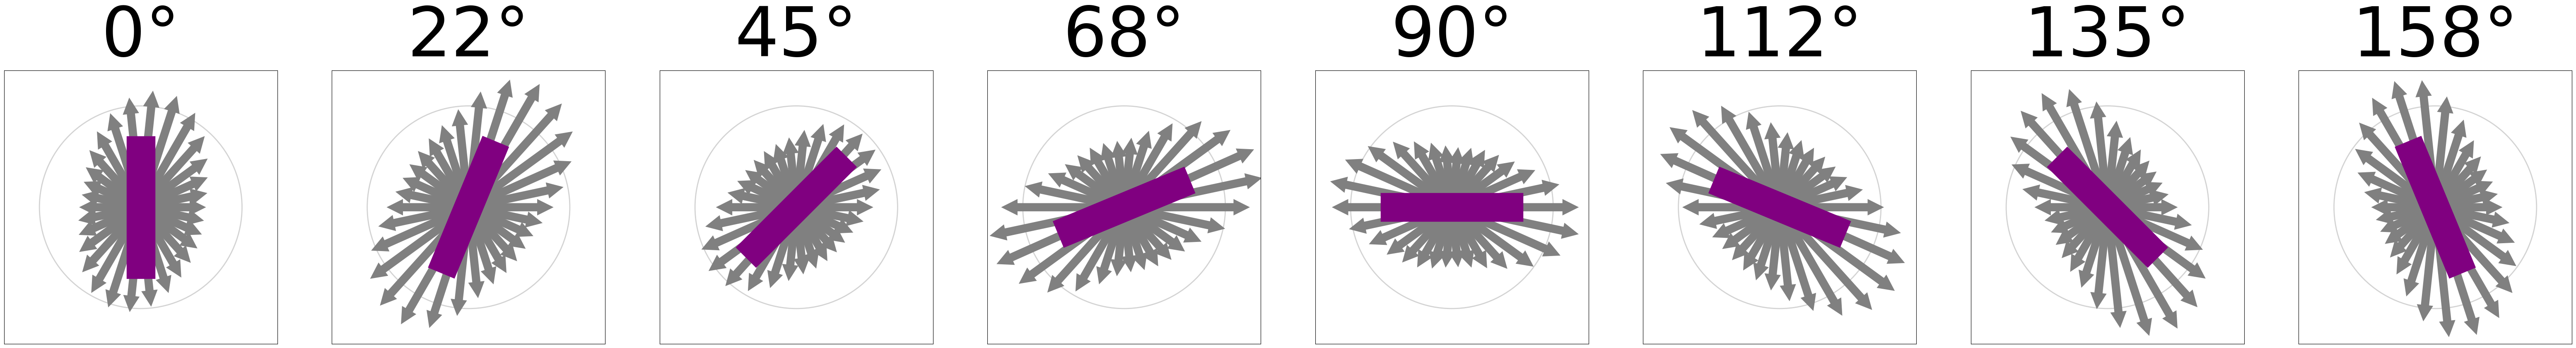

In [42]:
click_hand_full_delay_only1, angle_bins = compute_delay_patterns(click_lmb)

fig, ax = plt.subplots(1, N_BINS, figsize = (10*N_BINS, 10))
plot_1d_plot(click_hand_full_delay_only1, angle_bins, ax, method='vector')

hand_delay_plot_only1_path = os.path.join(PLOTS_FOLDER, 'click_delay_feature_vector.png')
plt.savefig(hand_delay_plot_only1_path)

### Inverted Encoding

In [188]:
from utils.inverted_encoding import deg_signed_diff, ForwardModel

In [189]:
DEFAULT_FEATURE_CONVERSION = {
    # '0d': { 'old': np.array([0, 1]),},
    '1d': {
        'old': np.arange(0, 30),
        'zoom_ratio': 1.0,
    },
}

#### find the best sharpness

In [190]:
ISI_phase = np.arange(start=2500//50, stop=3000//50).astype(int) # 10 time points
delay_phases = np.split(delay_phase, 9) # 9 x 10 time points

In [191]:
sharpness_range = [0.5, 1, 2, 4, 6, 8, 10, 12, 14, 16, 20, 30, 40]

In [192]:
from utils.inverted_encoding import raw_reformat_all_loaded

def reformat_all_loaded(phase, stim_names, cond_lmb):
    return raw_reformat_all_loaded(
        load_func=load_subject_time_feature,
        subjs=all_subjs,
        phase=phase, stim_names=stim_names, 
        cond_lmb=cond_lmb
    )

In [193]:
valid_1st_lmb = lambda df: ((df['stim_1_to_report']) | (df['trial_code'] == 1)).to_numpy()
ISI_xs, ISI_ys, _, _ = reformat_all_loaded(ISI_phase, ['stim_1'], valid_1st_lmb)

In [194]:
N_DEFAULT_CHANNELS = 18 # it seems yeild the best accuracy?

In [195]:
ISI_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION, n_channels=N_DEFAULT_CHANNELS)
ISI_best_sharpness, ISI_best_loss = ISI_forward_model.find_best_y_transform(
    ISI_xs, ISI_ys, item_weights=np.ones_like(ISI_ys), 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=10)
print(f'ISI best sharpness: {ISI_best_sharpness}, loss: {ISI_best_loss}')

sharpness 0.50 loss 0.383367 (invalid: 0.00)
sharpness 1.00 loss 0.383367 (invalid: 0.00)
sharpness 2.00 loss 0.383372 (invalid: 0.00)
sharpness 4.00 loss 0.383362 (invalid: 0.00)
sharpness 6.00 loss 0.383399 (invalid: 0.00)
sharpness 8.00 loss 0.383429 (invalid: 0.00)
sharpness 10.00 loss 0.383570 (invalid: 0.00)
sharpness 12.00 loss 0.383489 (invalid: 0.00)
sharpness 14.00 loss 0.383486 (invalid: 0.00)
sharpness 16.00 loss 0.383484 (invalid: 0.00)
sharpness 20.00 loss 0.383480 (invalid: 0.00)
sharpness 30.00 loss 0.383465 (invalid: 0.00)
sharpness 40.00 loss 0.383448 (invalid: 0.00)
ISI best sharpness: 4, loss: 0.38336232645833024


In [196]:
valid_both_lmb = lambda df: (
    (df['stim_1_to_report'] & df['stim_2_to_report']) | 
    (df['trial_code'] == 1)).to_numpy()

delay_xs, delay_ys, delay_dfs, _ = reformat_all_loaded(
    delay_phase, ['stim_1', 'stim_2'], valid_both_lmb)

In [197]:
from utils.inverted_encoding import convert_df_to_delay_design_matrix
item_weights_lmb = lambda df: convert_df_to_delay_design_matrix(df)

In [198]:
delay_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION, n_channels=N_DEFAULT_CHANNELS)
item_weights = item_weights_lmb(delay_dfs)
delay_best_sharpness, delay_best_loss = delay_forward_model.find_best_y_transform(
    delay_xs, delay_ys, item_weights=item_weights, 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=10)
print(f'Delay best sharpness: {delay_best_sharpness}, loss: {delay_best_loss}')

sharpness 0.50 loss 0.375295 (invalid: 0.00)
sharpness 1.00 loss 0.375295 (invalid: 0.00)
sharpness 2.00 loss 0.375291 (invalid: 0.00)
sharpness 4.00 loss 0.375268 (invalid: 0.00)
sharpness 6.00 loss 0.375330 (invalid: 0.00)
sharpness 8.00 loss 0.375258 (invalid: 0.00)
sharpness 10.00 loss 0.375252 (invalid: 0.00)
sharpness 12.00 loss 0.375237 (invalid: 0.00)
sharpness 14.00 loss 0.375237 (invalid: 0.00)
sharpness 16.00 loss 0.375237 (invalid: 0.00)
sharpness 20.00 loss 0.375236 (invalid: 0.00)
sharpness 30.00 loss 0.375235 (invalid: 0.00)
sharpness 40.00 loss 0.375237 (invalid: 0.00)
Delay best sharpness: 30, loss: 0.3752349117466676


#### Start training & testing

In [199]:
DEFAULT_FORWARD_MODEL_PARAMS = {
    'init': {
        'feature_conversion_params': DEFAULT_FEATURE_CONVERSION,
        'n_channels': N_DEFAULT_CHANNELS,
    },
    'forward': {
        'sharpness': delay_best_sharpness,
    }
}

In [200]:
delay_model = ForwardModel(**DEFAULT_FORWARD_MODEL_PARAMS['init'])

In [201]:
from utils.inverted_encoding import raw_across_subj_cross_phase_iterator

def across_subj_cross_phase_iterator(*args, **kwargs):
    return raw_across_subj_cross_phase_iterator(
        reformat_all_loaded,
        *args, **kwargs
    )

from utils.inverted_encoding import raw_cv_train_test_invert_encoding

def cv_train_test_invert_encoding(*args, **kwargs):
    return raw_cv_train_test_invert_encoding(
        across_subj_cross_phase_iterator,
        *args, **kwargs
    )

In [202]:
n_subjects = len(all_subjs)
full_delay_phase_results = cv_train_test_invert_encoding(
    DEFAULT_FORWARD_MODEL_PARAMS, 
    delay_phase, delay_phase, 
    ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
    # valid_both_lmb, valid_both_lmb, 
    None, None,
    item_weights_lmb, n_subjects)

In [203]:
DELAY_CHANNEL_PRED_MEAN = np.mean(full_delay_phase_results['preds'])
DELAY_CHANNEL_PRED_STD = np.std(full_delay_phase_results['preds'])
print(f'Delay channel prediction mean: {DELAY_CHANNEL_PRED_MEAN:.2f} std: {DELAY_CHANNEL_PRED_STD:.2f}')

Delay channel prediction mean: 0.06 std: 1.59


In [204]:
from utils.inverted_encoding import raw_channel_weights_to_pseudo_distrib

def channel_weights_to_pseudo_distrib(channel_weights, model, sharpness):
    return raw_channel_weights_to_pseudo_distrib(
       channel_weights, model, sharpness,
       delay_channel_pred_mean=DELAY_CHANNEL_PRED_MEAN,
       delay_channel_pred_std=DELAY_CHANNEL_PRED_STD
    )
    

In [205]:
from utils.inverted_encoding import raw_display_shifted_distrib

def display_shifted_distrib(*args, **kwargs):
    if 'ylim_min' not in kwargs:
        kwargs['ylim_min'] = 0.0040
    if 'ylim_max' not in kwargs:
        kwargs['ylim_max'] = 0.0075
    return raw_display_shifted_distrib(*args, **kwargs)

from utils.inverted_encoding import raw_display_stats_and_distrib

def display_stats_and_distrib(
        ax, # set to None to disable visualization
        results, stats_type, 
        common_lmb=None, condition_lmbs={}, item_weights_lmb=None, 
        sharpness=delay_best_sharpness, # sharpness to convert to distrib
        return_subj_stats=False # if to return each subject's stats
    ):
    return raw_display_stats_and_distrib(
        ax, results, stats_type, 
        common_lmb=common_lmb, condition_lmbs=condition_lmbs, 
        item_weights_lmb=item_weights_lmb,
        sharpness=sharpness, return_subj_stats=return_subj_stats,
        surrogate_model=delay_model,
        prediction_conversion_func=channel_weights_to_pseudo_distrib,
        display_shifted_distrib_func=display_shifted_distrib
    )

In [206]:
has_valid_prev_lmb = lambda df: ~(df['prev_last_response'].isna().values)
has_valid_prev_mask = has_valid_prev_lmb(full_delay_phase_results['test_df'])

In [207]:
DEF_PLOT_W, DEF_PLOT_H = 6, 6

In [208]:
from utils.inverted_encoding import print_stats_results_as_tables

--- accuracy ---
           mean    sem  t_stat   p_val
stim 1    0.329  0.086  3.7822  0.0006
stim 2    0.258  0.059  4.2875  0.0001
combined  0.295  0.065  4.4839  0.0001
--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1    0.127       0.112  1.1127  0.2734
stim 2    0.071       0.115  0.6040  0.5498
combined  0.099       0.083  1.1768  0.2472


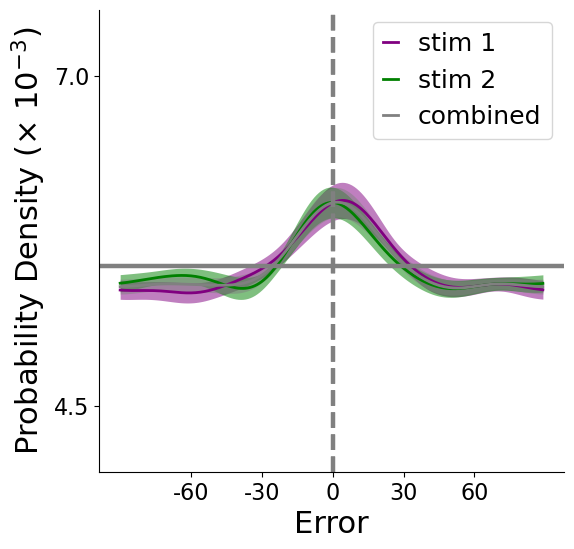

In [209]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=valid_both_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('Errors: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_delay.png')
plt.savefig(plot_path, bbox_inches='tight')


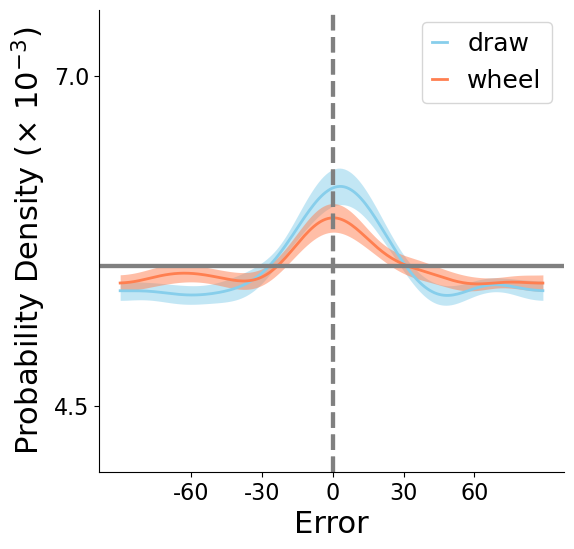

In [290]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))

plot_settings = {
    'draw': {
        'target': 'combined',
        'lmb': draw_lmb,
        'plot_settings': {
            'plot_line_color': MODE_COLORS['draw'],
            'plot_line_style': '-',
            'plot_line_alpha': 1,
        },
    },
    'wheel': {
        'target': 'combined',
        'lmb': click_lmb,
        'plot_settings': {
            'plot_line_color': MODE_COLORS['click'],
            'plot_line_style': '-',
            'plot_line_alpha': 1,
        },
    },
}

_, stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=valid_both_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb,
    return_subj_stats=True)

# ax.set_title('Errors: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_delay_draw_click.png')
plt.savefig(plot_path, bbox_inches='tight')

In [291]:
from utils.inverted_encoding import display_ttest_rel2_results

display_ttest_rel2_results(stats_results, ['draw', 'wheel'])

accuracy: 3.0024 (p=0.0049)
bias: 0.3324 (p=0.7416)


#### Compare Draw v.s. Click

In [212]:
draw_delay_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_delay_lmb = lambda df: (df['mode'] == 'click').to_numpy()
mode_lmbs = {
    'draw': draw_delay_lmb,
    'click': click_delay_lmb,
}

In [213]:
all_delay_across_modes = {}
item_weights_lmb = lambda df: convert_df_to_delay_design_matrix(df)
for train_mode in ['draw', 'click']:
    for test_mode in ['draw', 'click']:
        print(f'Trained on {train_mode}, tested on {test_mode}')
        n_subjects = len(all_subjs)
        train_lmb = mode_lmbs[train_mode]
        test_lmb = mode_lmbs[test_mode]
        modes_delay_phase_results = cv_train_test_invert_encoding(
            DEFAULT_FORWARD_MODEL_PARAMS, 
            delay_phase, delay_phase, 
            ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
            train_lmb, test_lmb, 
            item_weights_lmb, n_subjects)
        all_delay_across_modes[(train_mode, test_mode)] = modes_delay_phase_results

Trained on draw, tested on draw
Trained on draw, tested on click
Trained on click, tested on draw
Trained on click, tested on click


In [214]:
mode_prev_lmbs = {
    'draw': lambda df: draw_lmb(df) & has_valid_prev_lmb(df),
    'click': lambda df: click_lmb(df) & has_valid_prev_lmb(df),
}

draw -> draw
draw -> click
click -> draw
click -> click


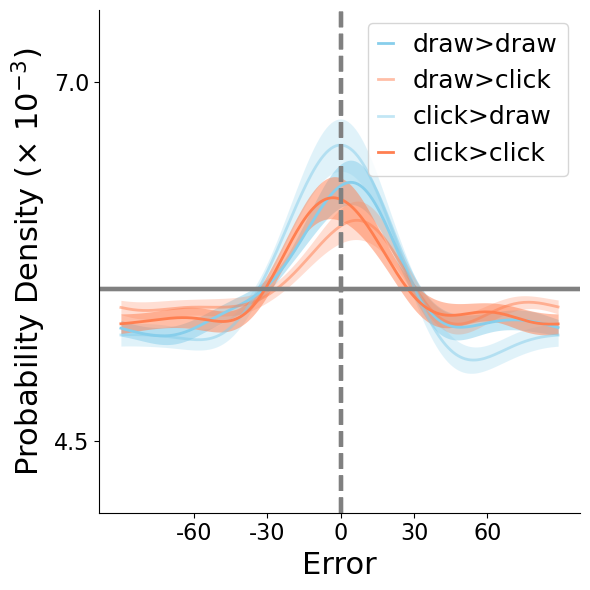

In [215]:
stim1_valid_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_1_to_report'])).to_numpy()
stim2_valid_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_2_to_report'])).to_numpy()

fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
across_modes_acc_stats = {}
for i, train_mode in enumerate(['draw', 'click']):
    for j, test_mode in enumerate(['draw', 'click']):
        print(f'{train_mode} -> {test_mode}')
        results = all_delay_across_modes[(train_mode, test_mode)]
        test_lmb = mode_lmbs[test_mode]

        # specific plot settings
        mode_cond_name = f'{train_mode}>{test_mode}'
        plot_alpha = 1 if test_mode == train_mode else 0.5
        plot_settings = {
            mode_cond_name: {
                'target': 'combined',
                'lmb': None,
                'plot_settings': {
                    'plot_line_color': MODE_COLORS[test_mode],
                    'plot_line_style': '-',
                    'plot_line_alpha': plot_alpha,
                },
            },
        }

        _, stats_results = display_stats_and_distrib(ax,
            results,
            stats_type='accuracy', 
            common_lmb=test_lmb, condition_lmbs=plot_settings,
            item_weights_lmb=item_weights_lmb,
            return_subj_stats=True)
        stats_results = stats_results[mode_cond_name]
        across_modes_acc_stats[f'{train_mode}->{test_mode}'] = stats_results

plt.tight_layout()
plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_delay_modes.png')
plt.savefig(plot_path, bbox_inches='tight')

In [216]:
from utils.inverted_encoding import anova_within_subject_test

In [217]:
_ = anova_within_subject_test(across_modes_acc_stats, 'accuracy')

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
condition 12.6606 3.0000 105.0000 0.0000

                    comparison  t_stat   p_val
0    draw->draw vs draw->click  1.9955  0.0538
1    draw->draw vs click->draw -1.2649  0.2143
2   draw->draw vs click->click  0.6500  0.5200
3   draw->click vs click->draw -2.6187  0.0130
4  draw->click vs click->click -1.2213  0.2301
5  click->draw vs click->click  1.9866  0.0548


#### also check the encoding and ISI phase

In [218]:
from copy import deepcopy

DEFAULT_ISI_FORWARD_MODEL_PARAMS = deepcopy(DEFAULT_FORWARD_MODEL_PARAMS)
DEFAULT_ISI_FORWARD_MODEL_PARAMS['forward']['sharpness'] = ISI_best_sharpness

In [219]:
valid_isi_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_1_to_report'])).to_numpy()
isi_item_weights_lmb = lambda df: np.array([
    np.ones(len(df)),
    np.zeros(len(df)),
]).T
isi_decode_results = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    ISI_phase, ISI_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  t_stat  p_val
stim 1  1.566  0.269  5.7328  0.000
stim 2  0.064  0.061  1.0389  0.306
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1  0.039       0.075  0.5146  0.6101
stim 2  0.059       0.057  1.0285  0.3108


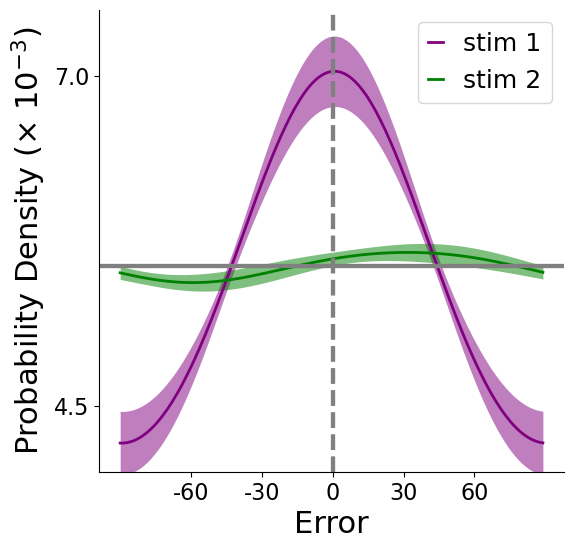

In [220]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    isi_decode_results,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_isi.png')
plt.savefig(plot_path, bbox_inches='tight')

In [221]:
enc1_phase_after_cue = np.arange(start=1500//50, stop=1750//50).astype(int)

enc1_decode_results_after_cue = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_after_cue, enc1_phase_after_cue, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  t_stat   p_val
stim 1  0.854  0.148  5.6871  0.0000
stim 2 -0.091  0.064 -1.4106  0.1672
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1 -0.033       0.059 -0.5470  0.5879
stim 2 -0.003       0.042 -0.0771  0.9390


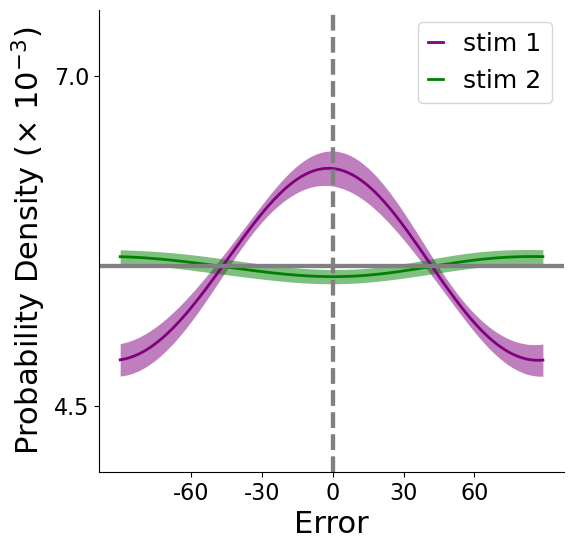

In [222]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_decode_results_after_cue,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_enc_after_cue.png')
plt.savefig(plot_path, bbox_inches='tight')

In [223]:
enc1_phase_during_cue = np.arange(start=1250//50, stop=1500//50).astype(int)

enc1_decode_results_during_cue = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_during_cue, enc1_phase_during_cue, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  t_stat   p_val
stim 1  0.162  0.072  2.2274  0.0324
stim 2  0.042  0.061  0.6829  0.4992
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1  0.040       0.046  0.8624  0.3943
stim 2  0.003       0.057  0.0596  0.9528


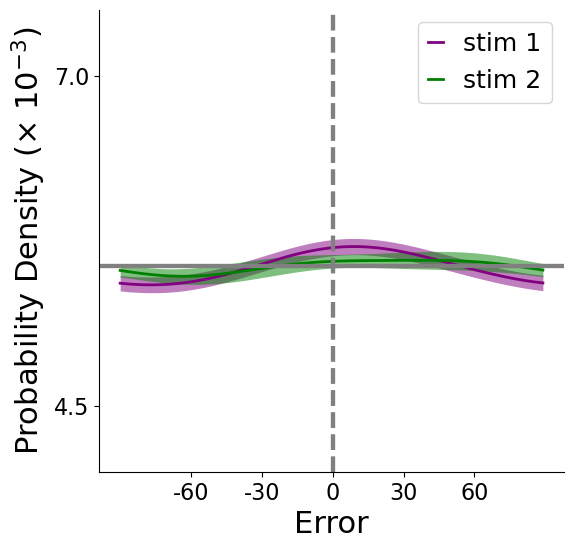

In [224]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_decode_results_during_cue,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_enc_during_cue.png')
plt.savefig(plot_path, bbox_inches='tight')

In [225]:
enc1_phase_before_cue = np.arange(start=1000//50, stop=1250//50).astype(int)

enc1_decode_results_before_cue = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_before_cue, enc1_phase_before_cue, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  t_stat  p_val
stim 1 -0.060  0.086 -0.6848  0.498
stim 2  0.093  0.078  1.1799  0.246
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1  0.043       0.039  1.0825  0.2864
stim 2 -0.025       0.049 -0.4970  0.6223


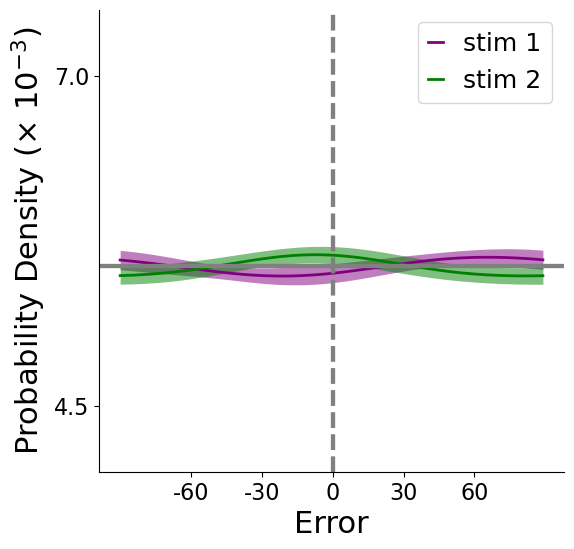

In [226]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_decode_results_before_cue,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_enc_before_cue.png')
plt.savefig(plot_path, bbox_inches='tight')

#### post-encoding phase

In [227]:
post_enc1_phase = np.arange(start=1750//50, stop=2250//50).astype(int)

post_enc1_decode_results = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    post_enc1_phase, post_enc1_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  t_stat  p_val
stim 1  1.334  0.268  4.9048  0.000
stim 2  0.049  0.048  1.0024  0.323
--- bias ---
         mean  sem (1e-3)  t_stat   p_val
stim 1  0.051       0.070  0.7175  0.4778
stim 2  0.009       0.047  0.1923  0.8486


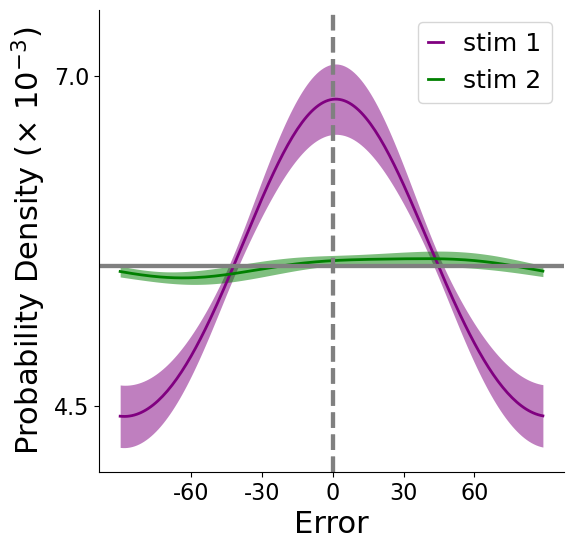

In [228]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    post_enc1_decode_results,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_post_enc1.png')
plt.savefig(plot_path, bbox_inches='tight')


In [229]:
post_enc2_phase = np.arange(start=4000//50, stop=4500//50).astype(int)
post_enc2_decode_results = cv_train_test_invert_encoding(
    DEFAULT_FORWARD_MODEL_PARAMS, 
    post_enc2_phase, post_enc2_phase, 
    ['stim_1', 'stim_2' ], ['stim_1', 'stim_2'], 
    None, None,
    item_weights_lmb, n_subjects)


--- accuracy ---
           mean    sem  t_stat   p_val
stim 1    0.203  0.062  3.2139  0.0028
stim 2    0.490  0.100  4.8441  0.0000
combined  0.348  0.057  5.9935  0.0000
--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1    0.071       0.089  0.7797  0.4408
stim 2   -0.012       0.101 -0.1215  0.9040
combined  0.040       0.079  0.5053  0.6165


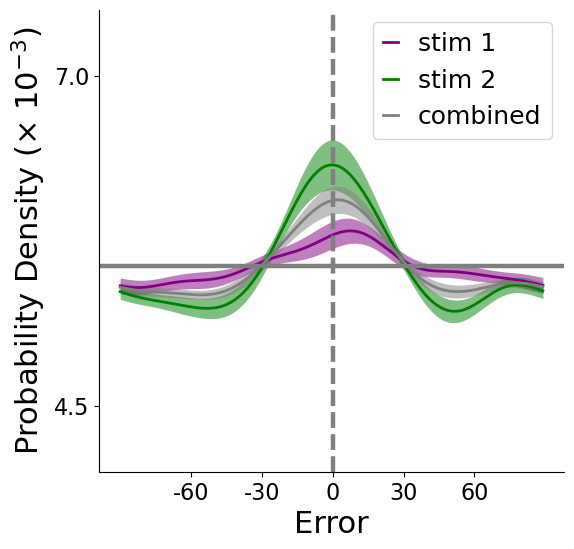

In [230]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    post_enc2_decode_results,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
# print(stats_results)
print_stats_results_as_tables(stats_results)
# ax.set_title('Errors: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_post_enc2.png')
plt.savefig(plot_path, bbox_inches='tight')


In [231]:
enc2_phase = np.arange(start=3750//50, stop=4000//50).astype(int)
enc2_decode_results = cv_train_test_invert_encoding(
    DEFAULT_FORWARD_MODEL_PARAMS, 
    enc2_phase, enc2_phase, 
    ['stim_1', 'stim_2' ], ['stim_1', 'stim_2'], 
    None, None,
    item_weights_lmb, n_subjects)

--- accuracy ---
           mean    sem  t_stat   p_val
stim 1    0.347  0.080  4.2700  0.0001
stim 2    0.228  0.057  3.9458  0.0004
combined  0.282  0.055  5.0511  0.0000
--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1    0.060       0.080  0.7440  0.4618
stim 2    0.014       0.060  0.2375  0.8136
combined  0.046       0.049  0.9207  0.3635


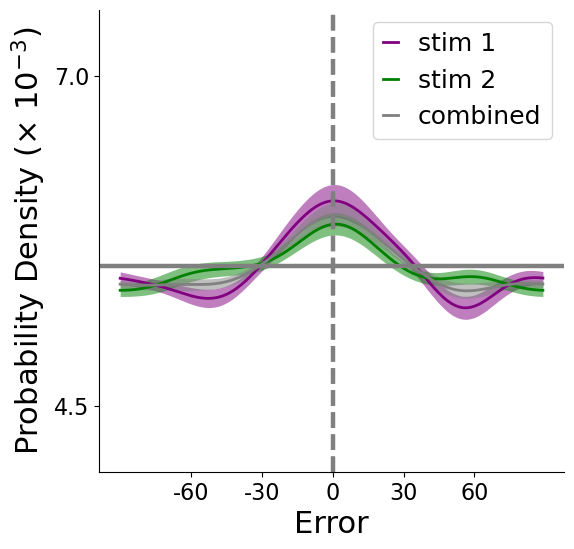

In [232]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    enc2_decode_results,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
# print(stats_results)
print_stats_results_as_tables(stats_results)
# ax.set_title('Errors: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_enc2.png')
plt.savefig(plot_path, bbox_inches='tight')


#### Serial Dependence?

In [68]:
from utils.inverted_encoding import generate_windows

DELAY_WINDOWS = generate_windows(delay_phase, 20, 7)
N_DELAY_WINDOW = len(DELAY_WINDOWS)
print(f'{N_DELAY_WINDOW} windows, each of {len(DELAY_WINDOWS[0])} time points')

11 windows, each of 20 time points


In [69]:
from utils.inverted_encoding import raw_within_across_phase_train_test

def within_across_phase_train_test(phases, train_test_lmb):
    return raw_within_across_phase_train_test(
        phases, train_test_lmb, 
        subjs=all_subjs,
        train_test_iterator=across_subj_cross_phase_iterator,
        model_params=DEFAULT_FORWARD_MODEL_PARAMS,
        item_weights_lmb=item_weights_lmb
    )

In [70]:
from utils.inverted_encoding import (
    raw_plot_single_stats_over_phase,
    raw_plot_stats_over_phase
)

def plot_single_stats_over_phase(
        ax, pred_results, stats_type, stat_name, phase_step,
        plot_settings, common_lmb, 
        plot_ymin=None, plot_ymax=None, label=None):

    return raw_plot_single_stats_over_phase(
        ax, pred_results, stats_type, stat_name, phase_step,
        plot_settings, common_lmb, 
        plot_ymin=plot_ymin, plot_ymax=plot_ymax, label=label,
        stats_computation_func=display_stats_and_distrib,
        item_weights_lmb=item_weights_lmb)

def plot_stats_over_phase(
        pred_results, stats_type, plot_settings, 
        common_lmb, plot_ymin=None, plot_ymax=None):
    return raw_plot_stats_over_phase(
        pred_results, stats_type, plot_settings,
        common_lmb, plot_ymin=plot_ymin, plot_ymax=plot_ymax,
        stats_computation_func=display_stats_and_distrib,
        item_weights_lmb=item_weights_lmb,
    )

In [71]:
mem2_cross_phase_results = within_across_phase_train_test(
    DELAY_WINDOWS, valid_both_lmb)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:44<00:00,  4.03s/it]


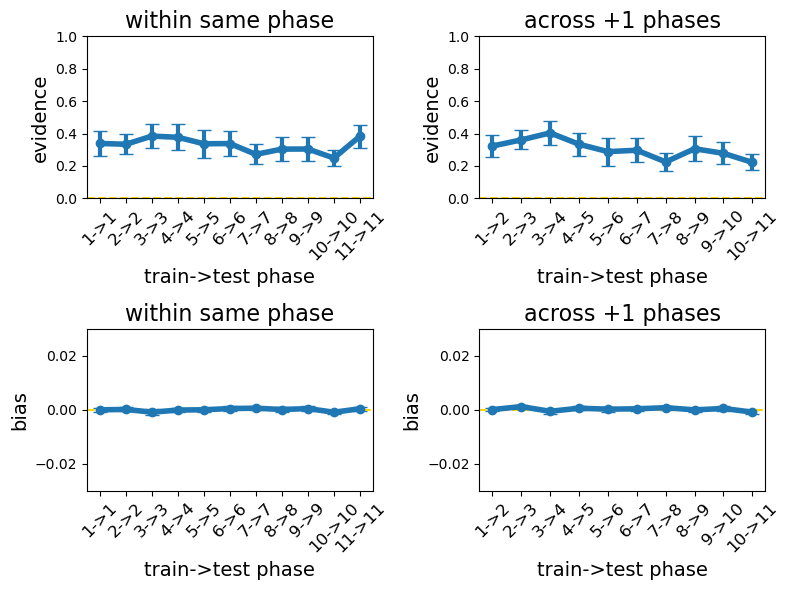

In [72]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    mem2_cross_phase_results, 'accuracy', 
    plot_settings, valid_both_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_delay_multi_phase_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [73]:
both_has_prev_lmb = lambda df: (has_valid_prev_lmb(df) & valid_both_lmb(df))

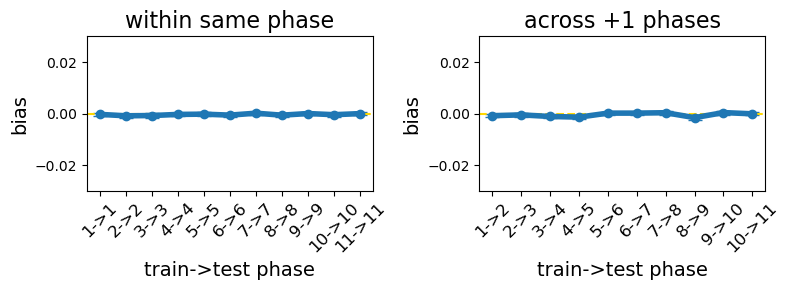

In [74]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    mem2_cross_phase_results, 'sd', 
    plot_settings, both_has_prev_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'inverted_enc_delay_multi_phase_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

#### Collect the accuracy score

In [75]:
STATS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'stats', 'mouse', 'inverted_enc')

In [76]:
def store_subject_stats(results, common_lmb, condition_lmbs, stats_type, cond_name,
        item_weights_lmb=item_weights_lmb, sharpness=delay_best_sharpness):
    # collect subject level stats
    stats_results = display_stats_and_distrib(
        ax=None,
        results=results, 
        stats_type=stats_type, 
        common_lmb=common_lmb, 
        condition_lmbs=condition_lmbs, 
        item_weights_lmb=item_weights_lmb, 
        sharpness=sharpness,
        return_subj_stats=True # need subject wise stats
    )
    stats_results = stats_results[1] # fetch only subject level stats

    # store it
    sub_result_folder = os.path.join(STATS_FOLDER, f'{cond_name}')
    os.makedirs(sub_result_folder, exist_ok=True)
    result_path = os.path.join(sub_result_folder, f'{stats_type}.json')
    with open(result_path, 'w') as f: 
        json.dump(stats_results, f, indent=4)

In [77]:
draw_both_lmb = lambda d: (draw_lmb(d) & valid_both_lmb(d))

stats_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

store_subject_stats(
    results=all_delay_across_modes[('draw', 'draw')], 
    common_lmb=draw_both_lmb, condition_lmbs=stats_settings, 
    stats_type='accuracy', cond_name='draw',
    item_weights_lmb=item_weights_lmb, sharpness=delay_best_sharpness)

In [78]:
click_both_lmb = lambda d: (click_lmb(d) & valid_both_lmb(d))

store_subject_stats(
    results=all_delay_across_modes[('click', 'click')], 
    common_lmb=click_both_lmb, condition_lmbs=stats_settings, 
    stats_type='accuracy', cond_name='click',
    item_weights_lmb=item_weights_lmb, sharpness=delay_best_sharpness)

### RSA

In [233]:
from abc import ABC, abstractmethod
from utils.distrib import color_smart_diff, color_smart_diff_outer
from scipy.spatial.distance import cdist

smart_diff = lambda x1, x2: color_smart_diff(x1, x2, vmin=-90, vmax=90)
smart_diff_outer = lambda x1, x2: color_smart_diff_outer(x1, x2, vmin=-90, vmax=90)

class DistFunctions:
    """ define all distance function """
    @classmethod
    def diff(cls, x1, x2, dist_name, pairwise):
        if dist_name == 'cos':
            return cls.cos_diff(x1, x2, pairwise)
        elif dist_name == 'euc':
            return cls.euclidean_diff(x1, x2, pairwise)
        elif dist_name == 'deg':
            return cls.deg_diff(x1, x2, pairwise)
        elif dist_name == 'rad':
            return cls.rad_diff(x1, x2, pairwise)
        else:
            raise NotImplementedError(f'Unknown distance {dist_name}')

    @classmethod
    def cos_diff(cls, x1, x2, pairwise):
        x1 = x1 / np.linalg.norm(x1, axis=-1, keepdims=True)
        x2 = x2 / np.linalg.norm(x2, axis=-1, keepdims=True)
        if pairwise:
            dists = cdist(x1, x2, metric='cosine')
        else:
            similarity = np.sum(x1 * x2, axis=-1)
            dists = 1 - similarity
        return dists

    @classmethod
    def euclidean_diff(cls, x1, x2, pairwise):
        if pairwise:
            dists = cdist(x1, x2, metric='euclidean')
        else:
            diffs = x1 - x2
            dists = np.linalg.norm(diffs, axis=-1)
        return dists
    
    @classmethod
    def deg_diff(cls, x1, x2, pairwise):
        if pairwise:
            dists = smart_diff_outer(x1, x2)
        else:
            dists = smart_diff(x1, x2)
        dists = np.abs(dists)
        return dists
    
    @classmethod
    def rad_diff(cls, x1, x2, pairwise):
        dists = cls.deg_diff(x1, x2, pairwise)
        dists = np.deg2rad(dists)
        return dists

In [255]:
from utils.rsa import RepresentationModel, RepRSAHelper

distrib_params = {"w": 0.14, "k_base": 27, "alpha": 1.0, "beta": 0.0,}
RepModel = RepresentationModel(distrib_params)
rsa_configs = {
    "channels": 18, # number of channels
    "channel_k": 5, # to compute weight for channels
}
rsa_helper = RepRSAHelper(**rsa_configs, rep_model=RepModel)


In [262]:
# get valid hand motion time steps
VALID_HAND_MOTION_TIME_STEPS = np.arange(1000//50, 9500//50).astype(int)

In [263]:
from utils.rsa import ALL_TIME_STEPS, raw_conditional_rsa_subj

def conditional_rsa_subj(
        subj, lmb, feature_mask, y_name, feature_dist_method):
    return raw_conditional_rsa_subj(
        subj, lmb, feature_mask, y_name, feature_dist_method,
        load_subject_time_feature, rsa_helper,
        time_steps=VALID_HAND_MOTION_TIME_STEPS)

In [277]:
from utils.rsa import raw_get_everyone_corr

def get_everyone_corr(lmb, feature_mask, y_name, feature_dist_method):
    return raw_get_everyone_corr(
        lmb, feature_mask, y_name, feature_dist_method,
        compute_subj_rsa_func=conditional_rsa_subj, 
        subjs=all_subjs)

In [274]:
from utils.rsa import raw_display_conditional_rsa

def display_conditional_rsa(ax, lmb, lmb_name, feature_mask, y_name, feature_dist_method, 
        color=None, alpha=1.0, linestyle='-'):
    return raw_display_conditional_rsa(
        ax, lmb, lmb_name, feature_mask, y_name, feature_dist_method, 
        color=color, alpha=alpha, linestyle=linestyle,
        get_rsa_corr_func=get_everyone_corr,
        display_time_steps=(VALID_HAND_MOTION_TIME_STEPS+0.5)*50)

In [275]:
from utils.rsa import raw_display_lmb_dicts_rsa

def display_lmb_dicts_rsa(ax, lmb_dicts, feature_mask, y_name, feature_dist_method, 
        colors=None, alphas=None, linestyles=None,
        show_legend=True):
    return raw_display_lmb_dicts_rsa(
        ax, lmb_dicts, feature_mask, y_name, feature_dist_method, 
        colors=colors, alphas=alphas, linestyles=linestyles,
        show_legend=show_legend,
        display_rsa_func=display_conditional_rsa)

In [249]:
draw_lmb = lambda d: (d['mode'] == 'draw').to_numpy()
click_lmb = lambda d: (d['mode'] == 'click').to_numpy()

In [250]:
draw_stim1_lmb = lambda d: (
    (d['mode'] == 'draw') & (d['stim_1_to_report'] | (d['trial_code'] == 1))).to_numpy()
click_stim1_lmb = lambda d: (
    (d['mode'] == 'click') & (d['stim_1_to_report'] | (d['trial_code'] == 1))).to_numpy()
draw_stim2_lmb = lambda d: (
    (d['mode'] == 'draw') & (d['stim_2_to_report'] | (d['trial_code'] == 1))).to_numpy()
click_stim2_lmb = lambda d: (
    (d['mode'] == 'click') & (d['stim_2_to_report'] | (d['trial_code'] == 1))).to_numpy()

100%|██████████| 36/36 [01:00<00:00,  1.68s/it]


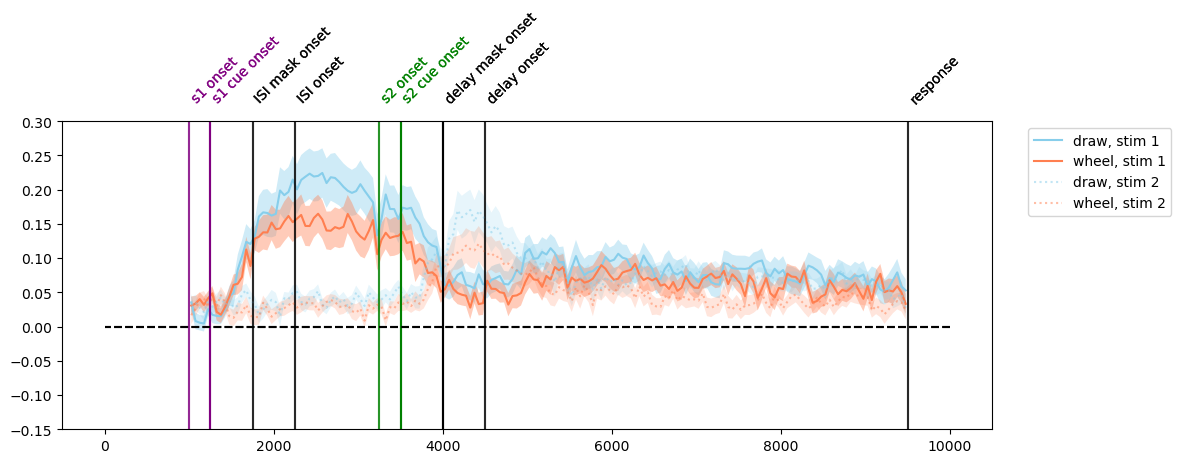

In [280]:
mode_masks = {
    'stim_1': {
        'draw, stim 1': draw_stim1_lmb,
        'wheel, stim 1': click_stim1_lmb,
    },
    'stim_2': {
        'draw, stim 2': draw_stim2_lmb,
        'wheel, stim 2': click_stim2_lmb,
    }
}

mode_colors = {
    'stim_1': {
        'draw, stim 1': 'skyblue',
        'wheel, stim 1': 'coral',
    },
    'stim_2': {
        'draw, stim 2': 'skyblue',
        'wheel, stim 2': 'coral',
    }
}

mode_alphas = {
    'stim_1': {
        'draw, stim 1': 1.0,
        'wheel, stim 1': 1.0,
    },
    'stim_2': {
        'draw, stim 2': 0.5,
        'wheel, stim 2': 0.5,
    }
}

mode_linestyles = {
    'stim_1': {
        'draw, stim 1': '-',
        'wheel, stim 1': '-',
    },
    'stim_2': {
        'draw, stim 2': ':',
        'wheel, stim 2': ':',
    }
}

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
to_show_legend = True
feature_mask = np.arange(30).astype(int)
feature_dist_method = 'cos'
for stim_id in ['stim_1', 'stim_2']:
    display_lmb_dicts_rsa(
        ax, mode_masks[stim_id], feature_mask, stim_id, 
        feature_dist_method, 
        colors=mode_colors[stim_id], 
        alphas=mode_alphas[stim_id],
        linestyles=mode_linestyles[stim_id],
        show_legend=to_show_legend)

plot_path = os.path.join(PLOTS_FOLDER, f'rsa.png')
plt.savefig(plot_path, bbox_inches='tight')